In [1]:
#!pip install numpy==1.15.4
#!pip install deepdish
#!pip install tensorflow==1.15

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import deepdish as dd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ISIS_dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#!pip install numpy==1.15.4

In [5]:
data = dd.io.load('ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [6]:
X_raw = data_df.image
Y = data_df.cell_type_idx

In [7]:
y_hot = pd.get_dummies(Y)

In [8]:
X = np.zeros((10015, 75, 100, 3))

for i in range(10015):
  X[i,:,:,:] = X_raw[i]

In [9]:
print("Tamaño datos X: {}".format(X.shape))
print("Tamaño datos Y: {}".format(y_hot.shape))

Tamaño datos X: (10015, 75, 100, 3)
Tamaño datos Y: (10015, 7)


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_hot, test_size = 0.3, random_state = 123)

In [11]:
X_train_norm = (X_train / np.max(X_train))
X_test_norm = (X_test / np.max(X_test))

In [12]:

X_train_norm.max()
X_train_norm.min()

0.0

In [13]:
from tensorflow import keras

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [15]:
from tensorflow.keras.layers import BatchNormalization

In [16]:
input_shape = (75, 100, 3)
num_classes = 7

classifier = Sequential()

# Convolution Step 1
classifier.add(Conv2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=input_shape, activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Conv2D(256, 2, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Conv2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
#classifier.add(Conv2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
#classifier.add(BatchNormalization())

# Convolution Step 5
#classifier.add(Conv2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPool2D(pool_size = (1, 1), strides = (1, 1), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1000, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Dense(units = num_classes, activation = 'softmax'))
classifier.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 17, 23, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 11, 96)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 11, 96)         384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 10, 256)        98560     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 5, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 5, 256)         1024      
_________________________________________

In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [19]:
classifier.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [23]:
# Fit the model
epochs = 50
batch_size = 30
history = classifier.fit_generator(datagen.flow(X_train_norm,Y_train, batch_size=batch_size),
                              epochs = epochs,
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
233/233 [==============================] - 16s 69ms/step - loss: 1.4027 - acc: 0.5805
Epoch 2/50
233/233 [==============================] - 12s 54ms/step - loss: 0.9561 - acc: 0.6659
Epoch 3/50
233/233 [==============================] - 13s 54ms/step - loss: 0.8937 - acc: 0.6914
Epoch 4/50
233/233 [==============================] - 13s 54ms/step - loss: 0.8389 - acc: 0.6960
Epoch 5/50
233/233 [==============================] - 12s 53ms/step - loss: 0.8031 - acc: 0.7024
Epoch 6/50
233/233 [==============================] - 13s 54ms/step - loss: 0.7873 - acc: 0.7159
Epoch 7/50
233/233 [==============================] - 12s 54ms/step - loss: 0.7638 - acc: 0.7216
Epoch 8/50
233/233 [==============================] - 13s 55ms/step - loss: 0.7424 - acc: 0.7252
Epoch 9/50
233/233 [==============================] - 13s 54ms/step - loss: 0.7272 - acc: 0.7328
Epoch 10/50
233/233 [==============================] - 13s 54ms/step - loss: 0.7407 - acc: 0.7301
Epoch 11/50
233/233 [========

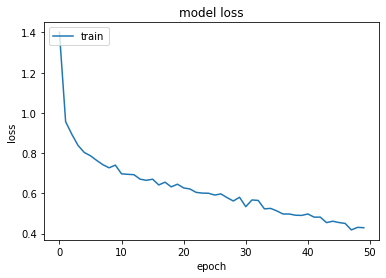

In [28]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    #plt.plot(hist.history["acc"], c = "r", name = "acc")
    #plt.plot(hist.history["val_loss"], c = "g")
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

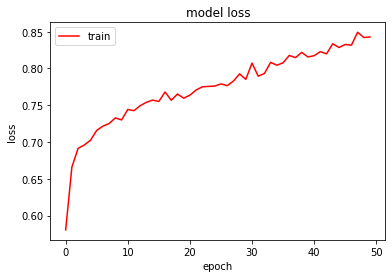

In [29]:
def plot_hist(hist):
    #plt.plot(hist.history["loss"])
    plt.plot(hist.history["acc"], c = "r")
    #plt.plot(hist.history["val_loss"], c = "g")
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [30]:
history.history.keys()

dict_keys(['loss', 'acc', 'lr'])

In [31]:
loss, accuracy = classifier.evaluate(X_test_norm, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

3005/3005 [==============================] - 1s 223us/sample - loss: 2.4167 - acc: 0.7311
Test: accuracy = 0.731115  ;  loss = 2.416691
